In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_classification, make_gaussian_quantiles
from sklearn.metrics import f1_score, accuracy_score, recall_score

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm

# Dataset

우선 One-Class SVM과 Isolation Forest의 작동 방식을 직관적으로 이해할 수 있도록 2차원의 데이터를 생성 해보겠습니다.

이때 정상 데이터의 군집의 갯수에 따라 모델이 다른 모습을 보이는지 확인하기 위해 정상 데이터의 군집을 1개 혹은 2개로 나누어서 진행 해보겠습니다.

In [2]:
n_normal = 1000

In [35]:
def make_dataset(n_normal, n_clusters, random_state, anomaly_ratio):
    
    if n_clusters == 1:
        X_normal = np.random.normal(0, 0.5, size=(n_normal,2))
        
    elif n_clusters == 2:
        X_normal = np.random.normal(7, 0.5, size=(int(n_normal/2),2))
        X_normal2 = np.random.normal(-7, 0.5, size=(int(n_normal/2),2))
        X_normal = np.concatenate([X_normal, X_normal2])
    
    y_normal = [1]*len(X_normal)
    
    X_anomaly, y_anomaly = make_gaussian_quantiles(n_samples=int(n_normal * anomaly_ratio * 3), n_features=2, cov=5, random_state=random_state)
    X_anomaly = X_anomaly[y_anomaly == 2]
    y_anomaly = y_anomaly[y_anomaly == 2]
    y_anomaly = [-1] * len(y_anomaly)
    
    X = np.concatenate([X_normal, X_anomaly])
    y = np.concatenate([y_normal, y_anomaly])
    
    return X, y

sklearn 패키지에서 제공하는 데이터 생성 함수를 활용하여 데이터 셋을 생성했습니다.  
make_gaussian_quantiles은 가우시안 분포의 데이터를 만들어주는 함수로, 여기서는 가우시안 분포의 평균으로부터 멀리 떨어져 있는 분포를 이상치로 사용하겠습니다.

In [36]:
X_1,y_1 = make_dataset(1000, 1, 58, 0.1)
X_2,y_2 = make_dataset(1000, 2, 58, 0.1)

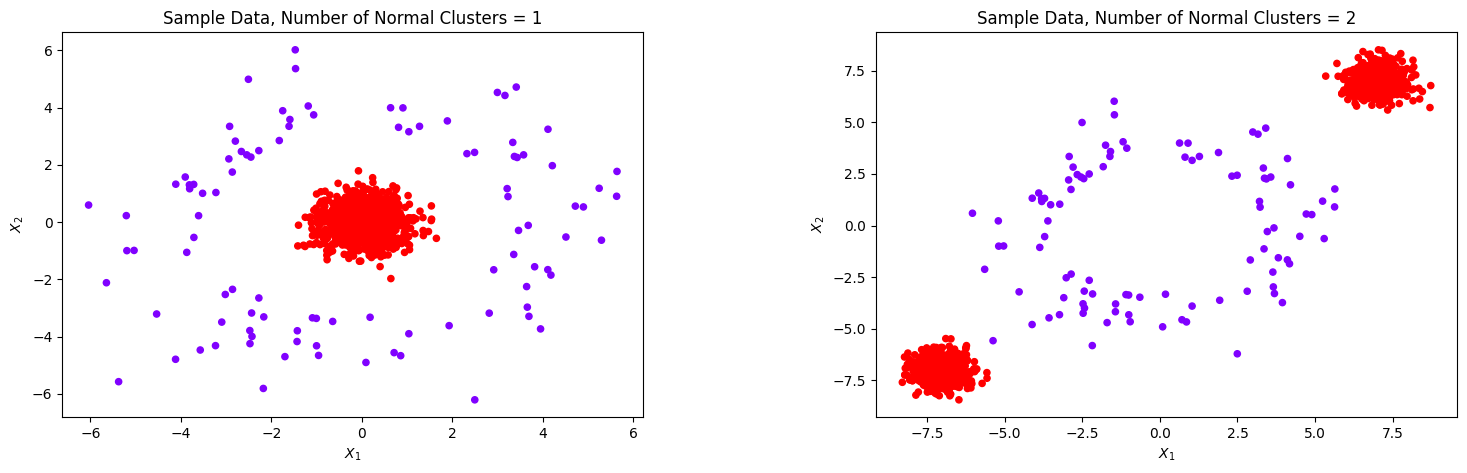

In [37]:
plt.figure(figsize=(18, 5)) 

# X_1
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.1)
plt.title('Sample Data, Number of Normal Clusters = 1')
plt.scatter(X_1[:,0], X_1[:,1], marker='o', c=y_1, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

# X_2
plt.subplot(1, 2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.1)

plt.title('Sample Data, Number of Normal Clusters = 2')
plt.scatter(X_2[:,0], X_2[:,1], marker='o', c=y_2, s=20, cmap=plt.cm.rainbow)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")

plt.show()

# One-Class SVM & iForest

## Number of Normal Clusters = 1

우선 정상 데이터의 군집이 1개로 형성되어 있는 데이터에서 실험해보도록 하겠습니다.

### One-Class SVM

이제 위에서 생성한 데이터를 활용하여 **One-Class SVM (OCSVM)** 을 학습 시켜보겠습니다. OCSVM도 SVM과 마찬가지로 다양한 커널을 활용 할 수 있습니다. 여기서는 일반적으로 가장 많이 사용되는 **rbf** 커널을 사용 하겠습니다.

여기서 기존의 SVM과는 다른 중요한 파라미터가 있습니다. 기존의 C 파라미터 대신 $\nu$를 사용하게 됩니다. $\nu$를 통해 support vector 개수의 하한선과 error로 부터 패널티를 받는 support vector 개수의 상한선을 조절 할 수 있습니다.

경험상, $\nu$에 따라 성능이 매우 천차만별로 크게 다르게 나타났기 때문에 $\nu$에 대해 집중적으로 다루어보겠습니다.

$\nu$가 클수록 에러를 허용하지 않기 때문에 더 학습 데이터의 분포를 많이 반영하여 결정 경계를 그리게 되고, 반대로 $\nu$가 작을수록 더 일반화 됩니다.

더 직관적으로 해석하면, One-Class SVM 에서는 $\nu$는 데이터에 얼마만큼의 이상치가 포함 되어 있는지를 의미한다고 볼 수도 있습니다. 즉 $\nu = 0.01$ 이라면 전체 데이터 중 1%가 이상치라고 설정한다고 볼 수도 있습니다. 

(https://yupsung.blogspot.com/2021/02/one-class-svm-svdd.html)

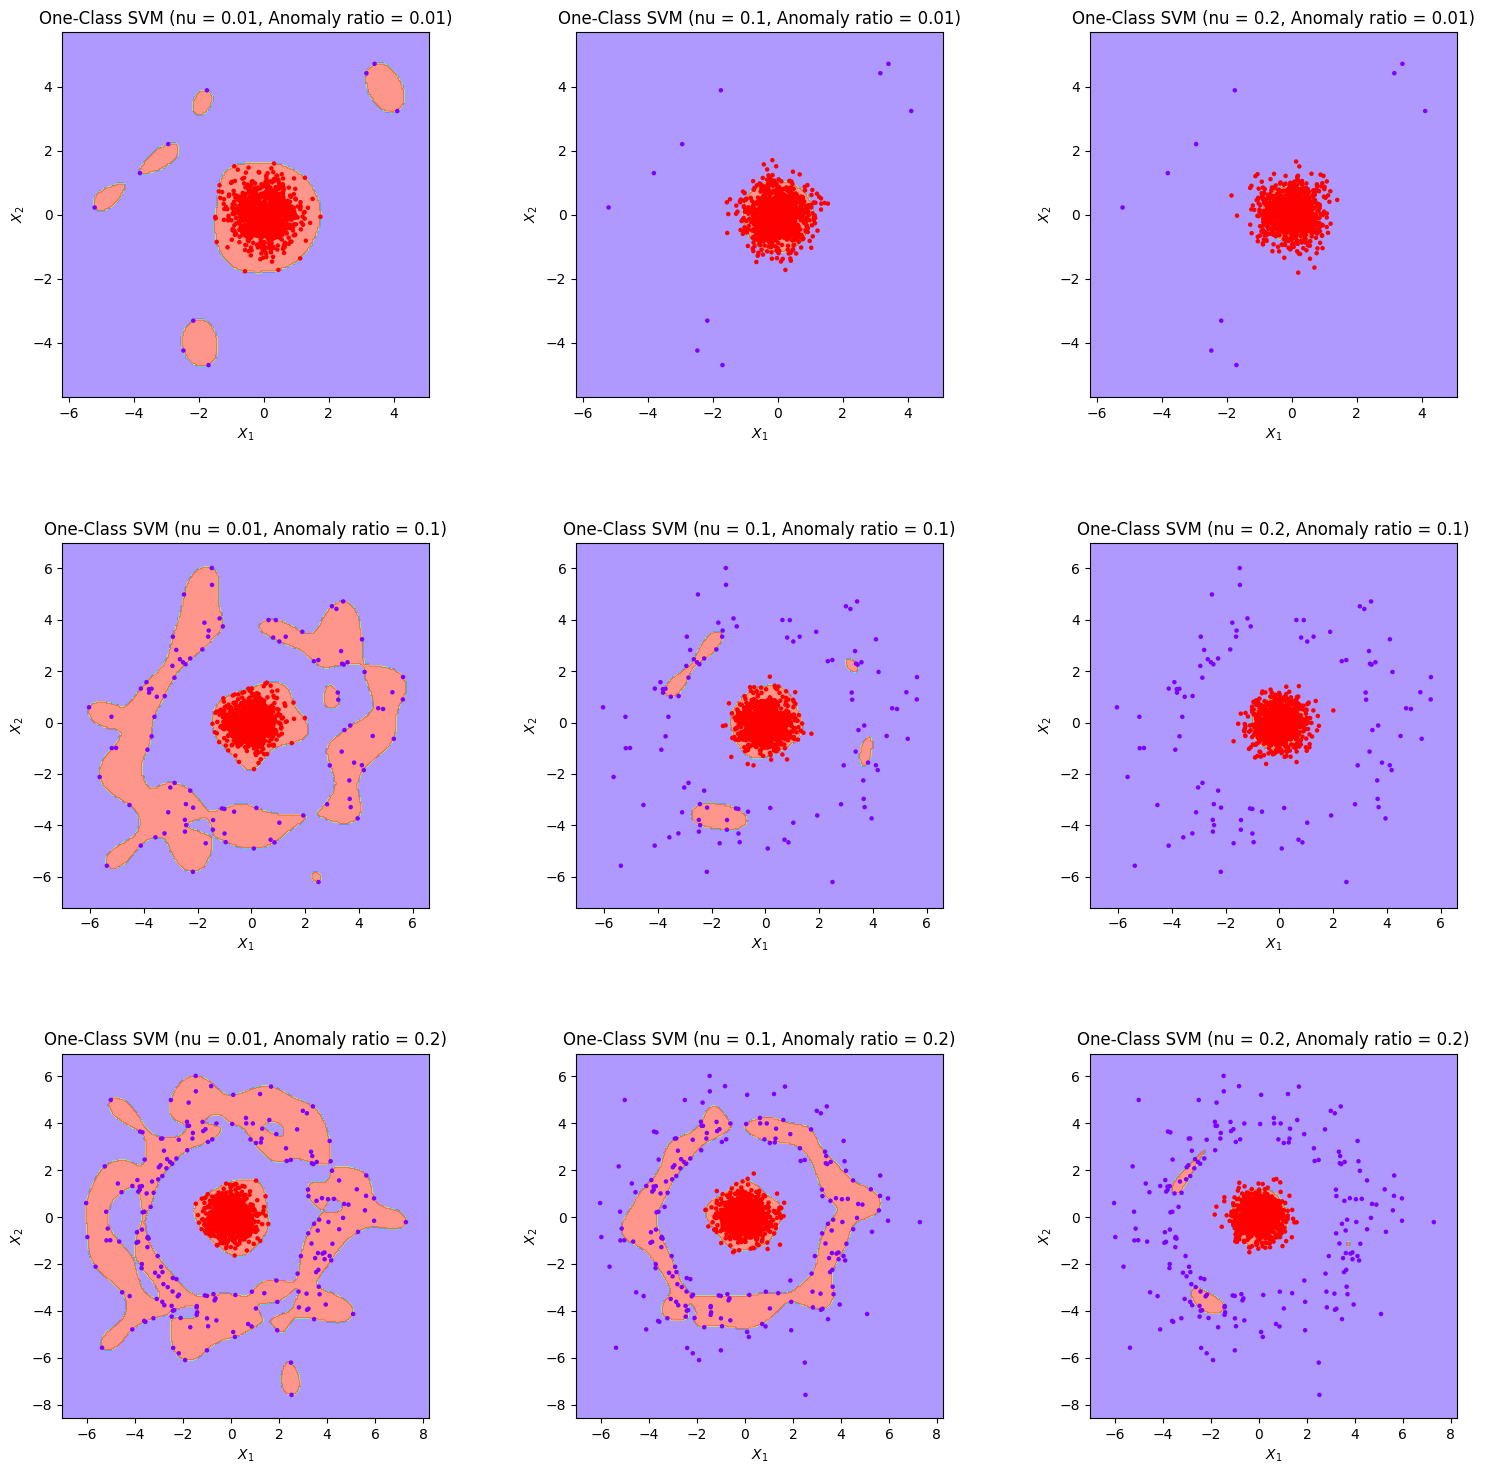

In [38]:
plt.figure(figsize=(18, 18)) 
for i, anomaly_ratio in enumerate([0.01, 0.1, 0.2]):
    for j, nu in enumerate([0.01, 0.1, 0.2]):
        
        X_1,y_1 = make_dataset(1000, 1, 58, anomaly_ratio)

        h = .05
        x_min, x_max = X_1[:, 0].min() - 1, X_1[:, 0].max() + 1
        y_min, y_max = X_1[:, 1].min() - 1, X_1[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        clf = OneClassSVM(gamma='auto', nu=nu).fit(X_1)
        
        
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.subplot(3, 3, (i*3)+j+1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.5)
        plt.scatter(X_1[:, 0], X_1[:, 1], c=y_1, cmap=plt.cm.rainbow, s=5)
        plt.title(f'One-Class SVM (nu = {nu}, Anomaly ratio = {anomaly_ratio})')
        
        plt.xlabel("$X_1$")
        plt.ylabel("$X_2$")

plt.show()

위 그림은 학습 데이터에 포함된 이상 데이터의 비율을 다르게 하며 각 경우에서 OCSVM의 $\nu$에 따라 결정 경계가 어떻게 변화하는지 그려본 모습입니다.

위 결과에서 다음과 같은 특징들을 살펴 볼 수 있습니다.

* 데이터에 포함된 이상치 비율에 비해 $\nu$를 지나치게 낮게 설정하면 데이터에 섞여있는 이상치도 정상 분포로 학습하게 됩니다. 특히 rbf 커널의 영향으로 정확히 데이터가 존재하는 곳 주변으로 결정 경계가 형성되고 있는 모습이 보이는데, 과적합의 위험이 크다고 볼 수 있습니다.
* 데이터에 포함된 이상치 비율에 비해 $\nu$를 지나치게 높게 설정하면 결정 경계를 지나치게 좁게 잡아 정상 데이터를 오분류하는 경우가 많아집니다.
* 일반적으로, 실제 이상치 비율과 $\nu$가 같을 때 가장 합리적인 결정 경계를 그리고 있는 것으로 보입니다.

## Isolation Forest

이제 같은 데이터를 활용하여 Isolation Forest에 대해 살펴보도록 하겠습니다.

Isolation Forest에도 OCSVM에 존재하던 $\nu$와 비슷한 역할을 하는 **contamination** 이라는 하이퍼 파라미터가 존재합니다.

Contamination은 학습 데이터에 포함된 이상치 데이터의 비율을 정의 할 수 있습니다. *Contamination = 0.01*이면 학습 데이터에 이상 데이터의 비율이 1% 라는 뜻이 됩니다.

OCSVM의 $\nu$와는 다르게 Isolation Forest의 저자는 contamination의 default 값을 설정하는 식을 제안하기 때문에, 따로 설정하지 않으면 논문에서 제안하는 방법에 따라 contamination의 값이 주어지게 됩니다. OCSVM에는 이러한 방법이 따로 존재하지 않습니다.

데이터에 포함된 이상 데이터의 비율을 알 수 없는 상황에서 합리적인 default 값을 제공해준다는 점에서 큰 장점이라고 볼 수 있습니다.


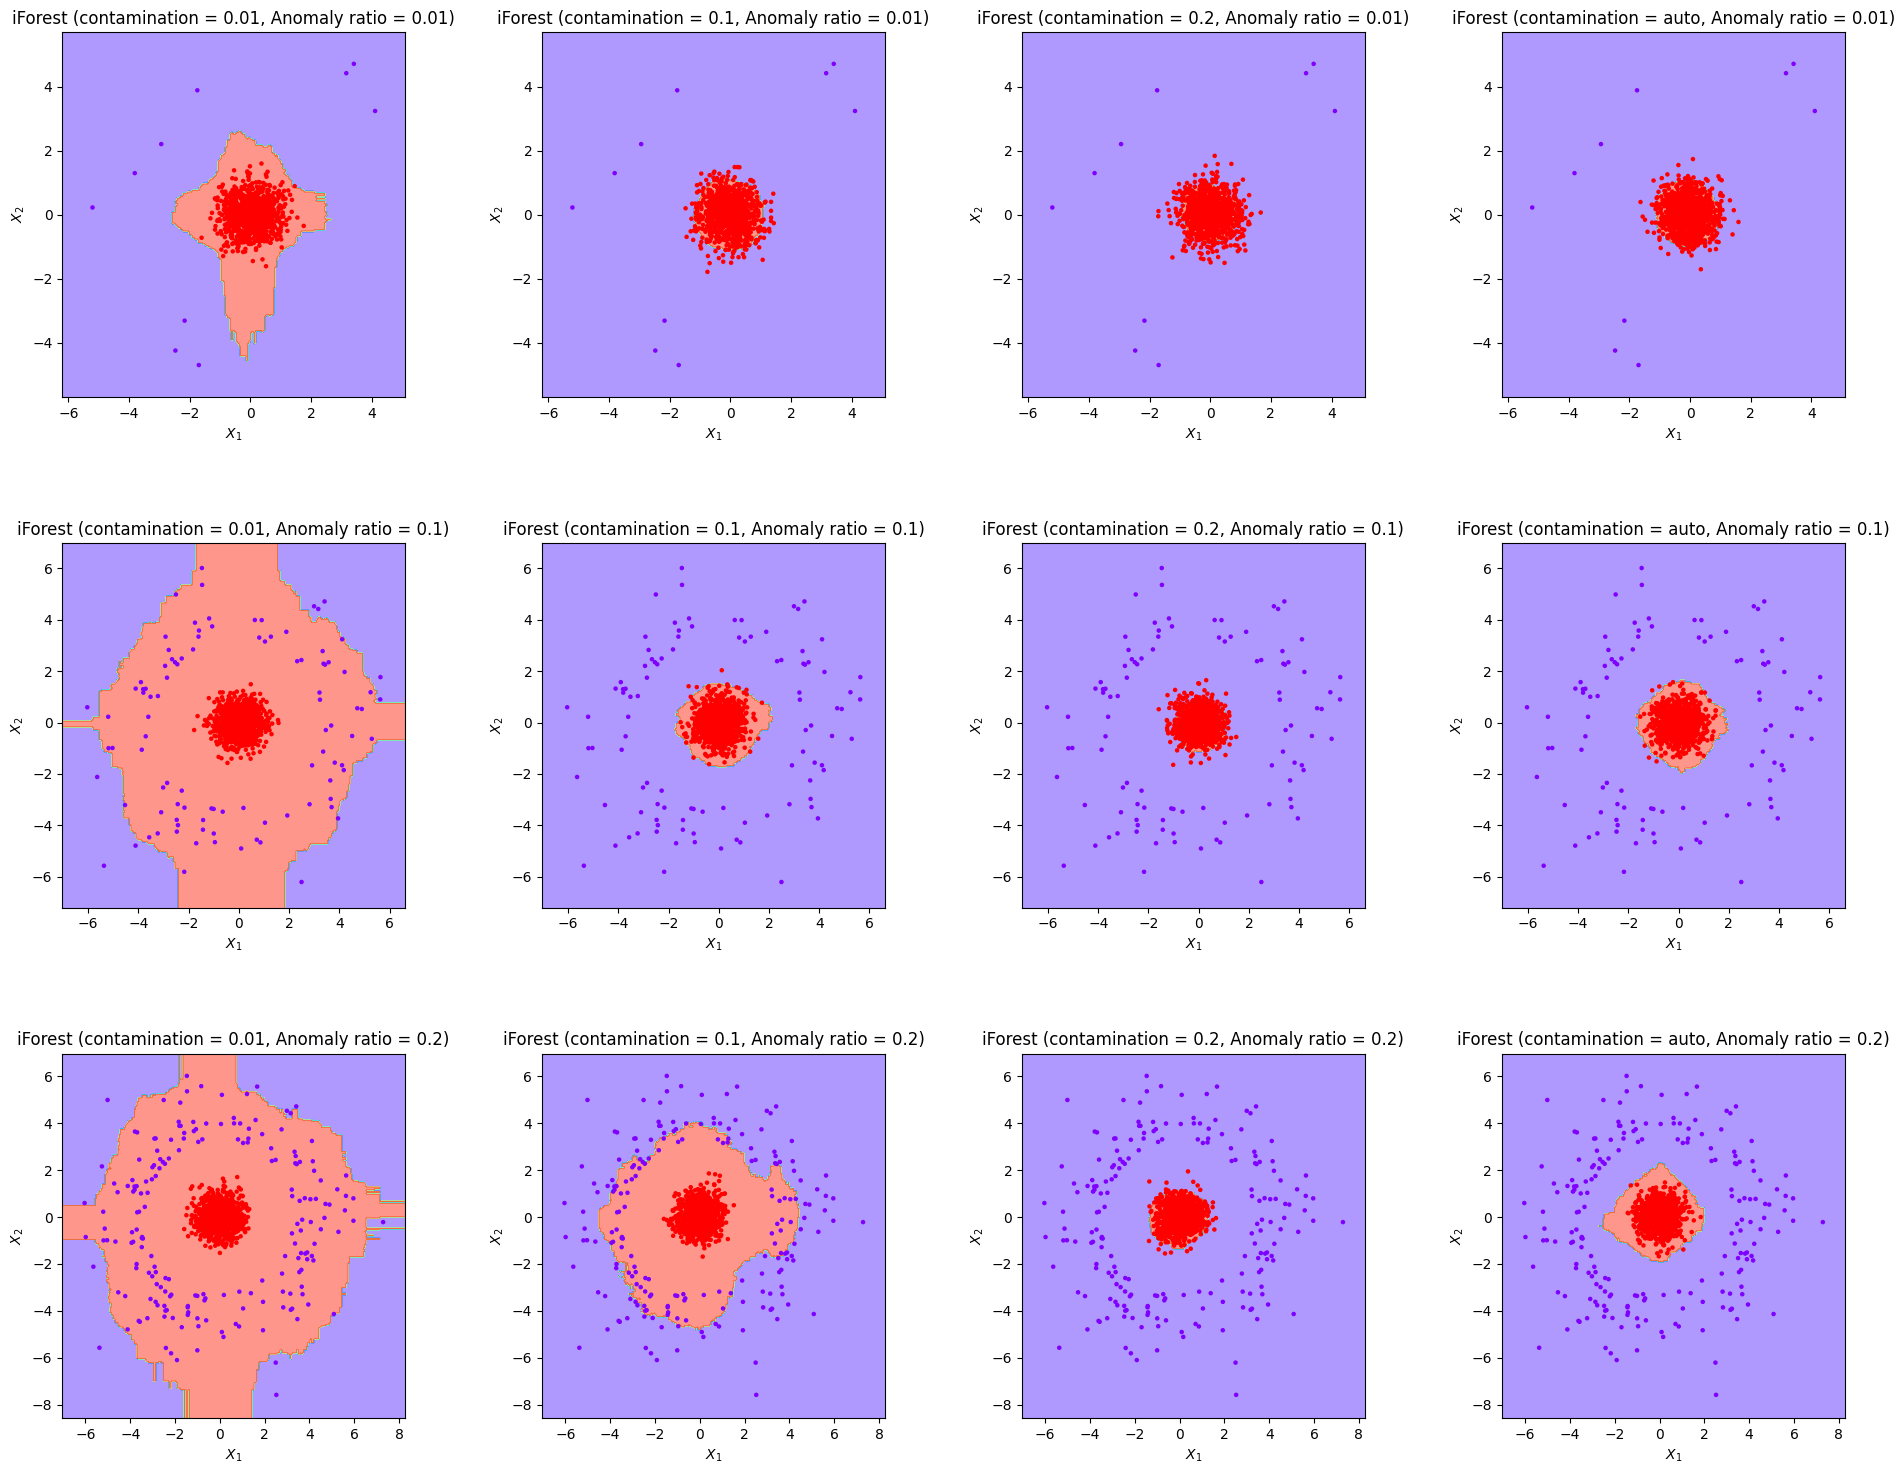

In [39]:
plt.figure(figsize=(23, 18)) 
for i, anomaly_ratio in enumerate([0.01, 0.1, 0.2]):
    for j, contamination in enumerate([0.01, 0.1, 0.2, 'auto']):
        
        X_1,y_1 = make_dataset(1000, 1, 58, anomaly_ratio)

        h = .05
        x_min, x_max = X_1[:, 0].min() - 1, X_1[:, 0].max() + 1
        y_min, y_max = X_1[:, 1].min() - 1, X_1[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        clf = IsolationForest(random_state=0, contamination=contamination).fit(X_1)
        
        
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.subplot(3, 4, (i*4)+j+1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.5)
        plt.scatter(X_1[:, 0], X_1[:, 1], c=y_1, cmap=plt.cm.rainbow, s=5)
        plt.title(f'iForest (contamination = {contamination}, Anomaly ratio = {anomaly_ratio})')
        
        plt.xlabel("$X_1$")
        plt.ylabel("$X_2$")

plt.show()

위 그림은 위와 마찬가지로 학습 데이터에 포함된 이상 데이터의 비율을 다르게 하여 Isolation Forest의 contamination 값을 다르게 준 결과입니다.

전체적으로 OCSVM과 비슷한 양상을 띄는 점을 확인 할 수 있습니다. 

구체적으로 위 결과에서 다음과 같은 특징들을 살펴 볼 수 있습니다.

* OCSVM과는 다르게, 선형적으로 결정 경계를 그리고 있는 모습을 확인할 수 있습니다.
* 데이터에 포함된 이상치 비율에 비해 contamination을 지나치게 낮게 설정하면 데이터에 섞여있는 이상치도 정상 분포로 학습하게 됩니다. 특히 이상 데이터가 존재하는 주변에만 결정 경계를 그렸던 OCSVM과는 다르게, tree 모델의 특징으로 영역 전체를 정상으로 판정하고 있습니다.
* 데이터에 포함된 이상치 비율에 비해 contamination을 지나치게 높게 설정하면 결정 경계를 지나치게 좁게 잡아 정상 데이터를 오분류하는 경우가 많아집니다.
* 일반적으로, 실제 이상치 비율과 $\nu$가 같을 때 합리적인 결정 경계를 그리고 있습니다. 
* 또한, 실제 이상치 비율과 상관없이 contamination = 'auto' 로 두었을 때 합리적인 결정 경계를 그리고 있습니다. 따라서 데이터에 이상치가 얼마나 포함되어 있는지 정보가 없는 경우에는 contamination = 'auto' 로 두는 것이 좋은 선택이 될 수 있습니다.

## Number of Normal Clusters = 2

이제 위와 같은 실험을 다른 데이터로 반복 해보겠습니다. 위에서는 하나의 가우시안 분포를 정상 분포로 두었는데, 실제로는 정상 데이터의 패턴은 다양하게 존재할 가능성이 높습니다. 

이러한 경우에 모델이 어떻게 작동하는지 확인하기 위해 정상 데이터의 Cluster를 늘려보았습니다.

### OCSVM

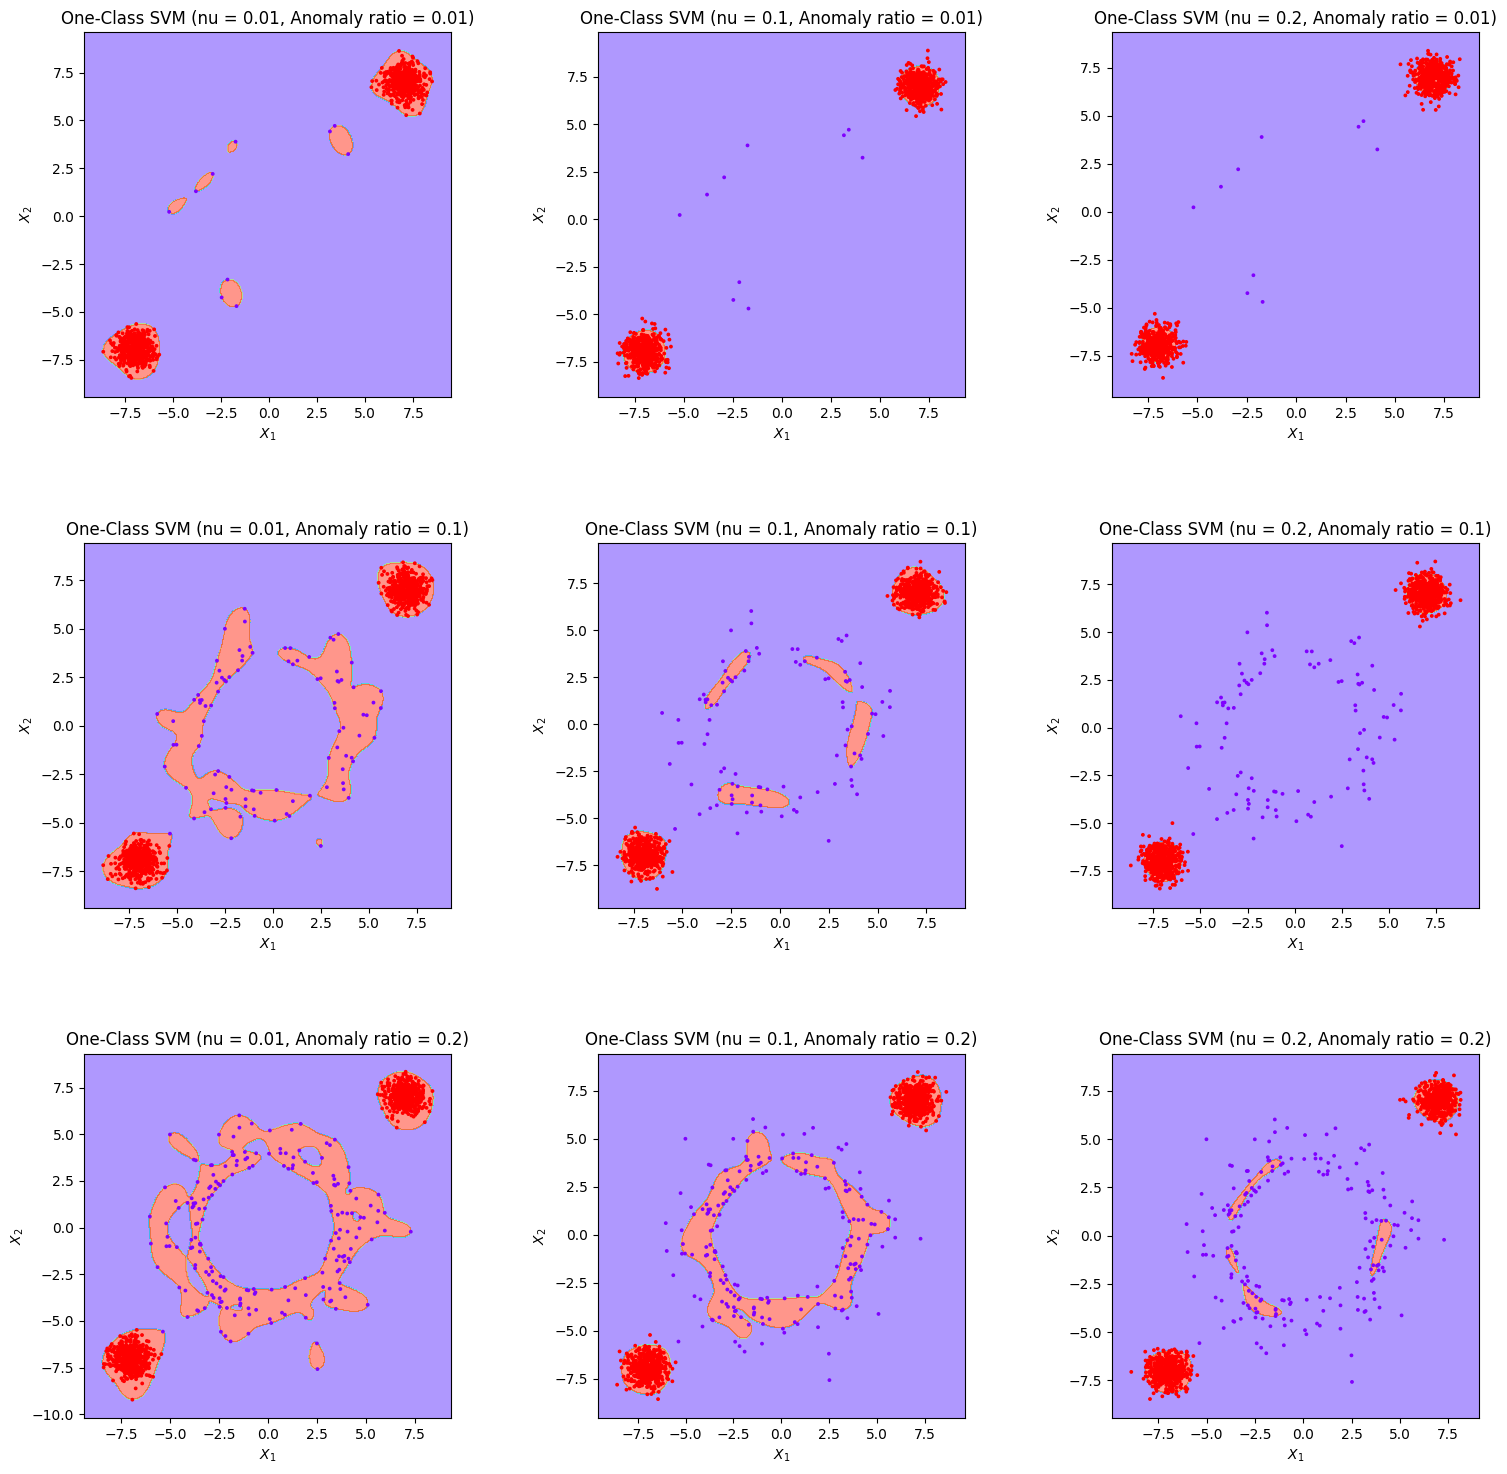

In [43]:
plt.figure(figsize=(18, 18)) 
for i, anomaly_ratio in enumerate([0.01, 0.1, 0.2]):
    for j, nu in enumerate([0.01, 0.1, 0.2]):
        
        X_1,y_1 = make_dataset(1000, 2, 58, anomaly_ratio)

        h = .05
        x_min, x_max = X_1[:, 0].min() - 1, X_1[:, 0].max() + 1
        y_min, y_max = X_1[:, 1].min() - 1, X_1[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        clf = OneClassSVM(gamma='auto', nu=nu).fit(X_1)
        
        
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.subplot(3, 3, (i*3)+j+1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.5)
        plt.scatter(X_1[:, 0], X_1[:, 1], c=y_1, cmap=plt.cm.rainbow, s=3)
        plt.title(f'One-Class SVM (nu = {nu}, Anomaly ratio = {anomaly_ratio})')
        
        plt.xlabel("$X_1$")
        plt.ylabel("$X_2$")

plt.show()

전반적으로 정상 데이터의 군집을 1개로 두었을 때와 비슷한 양상을 띄고 있는 것으로 확인 할 수 있습니다.

### Isolation Forest

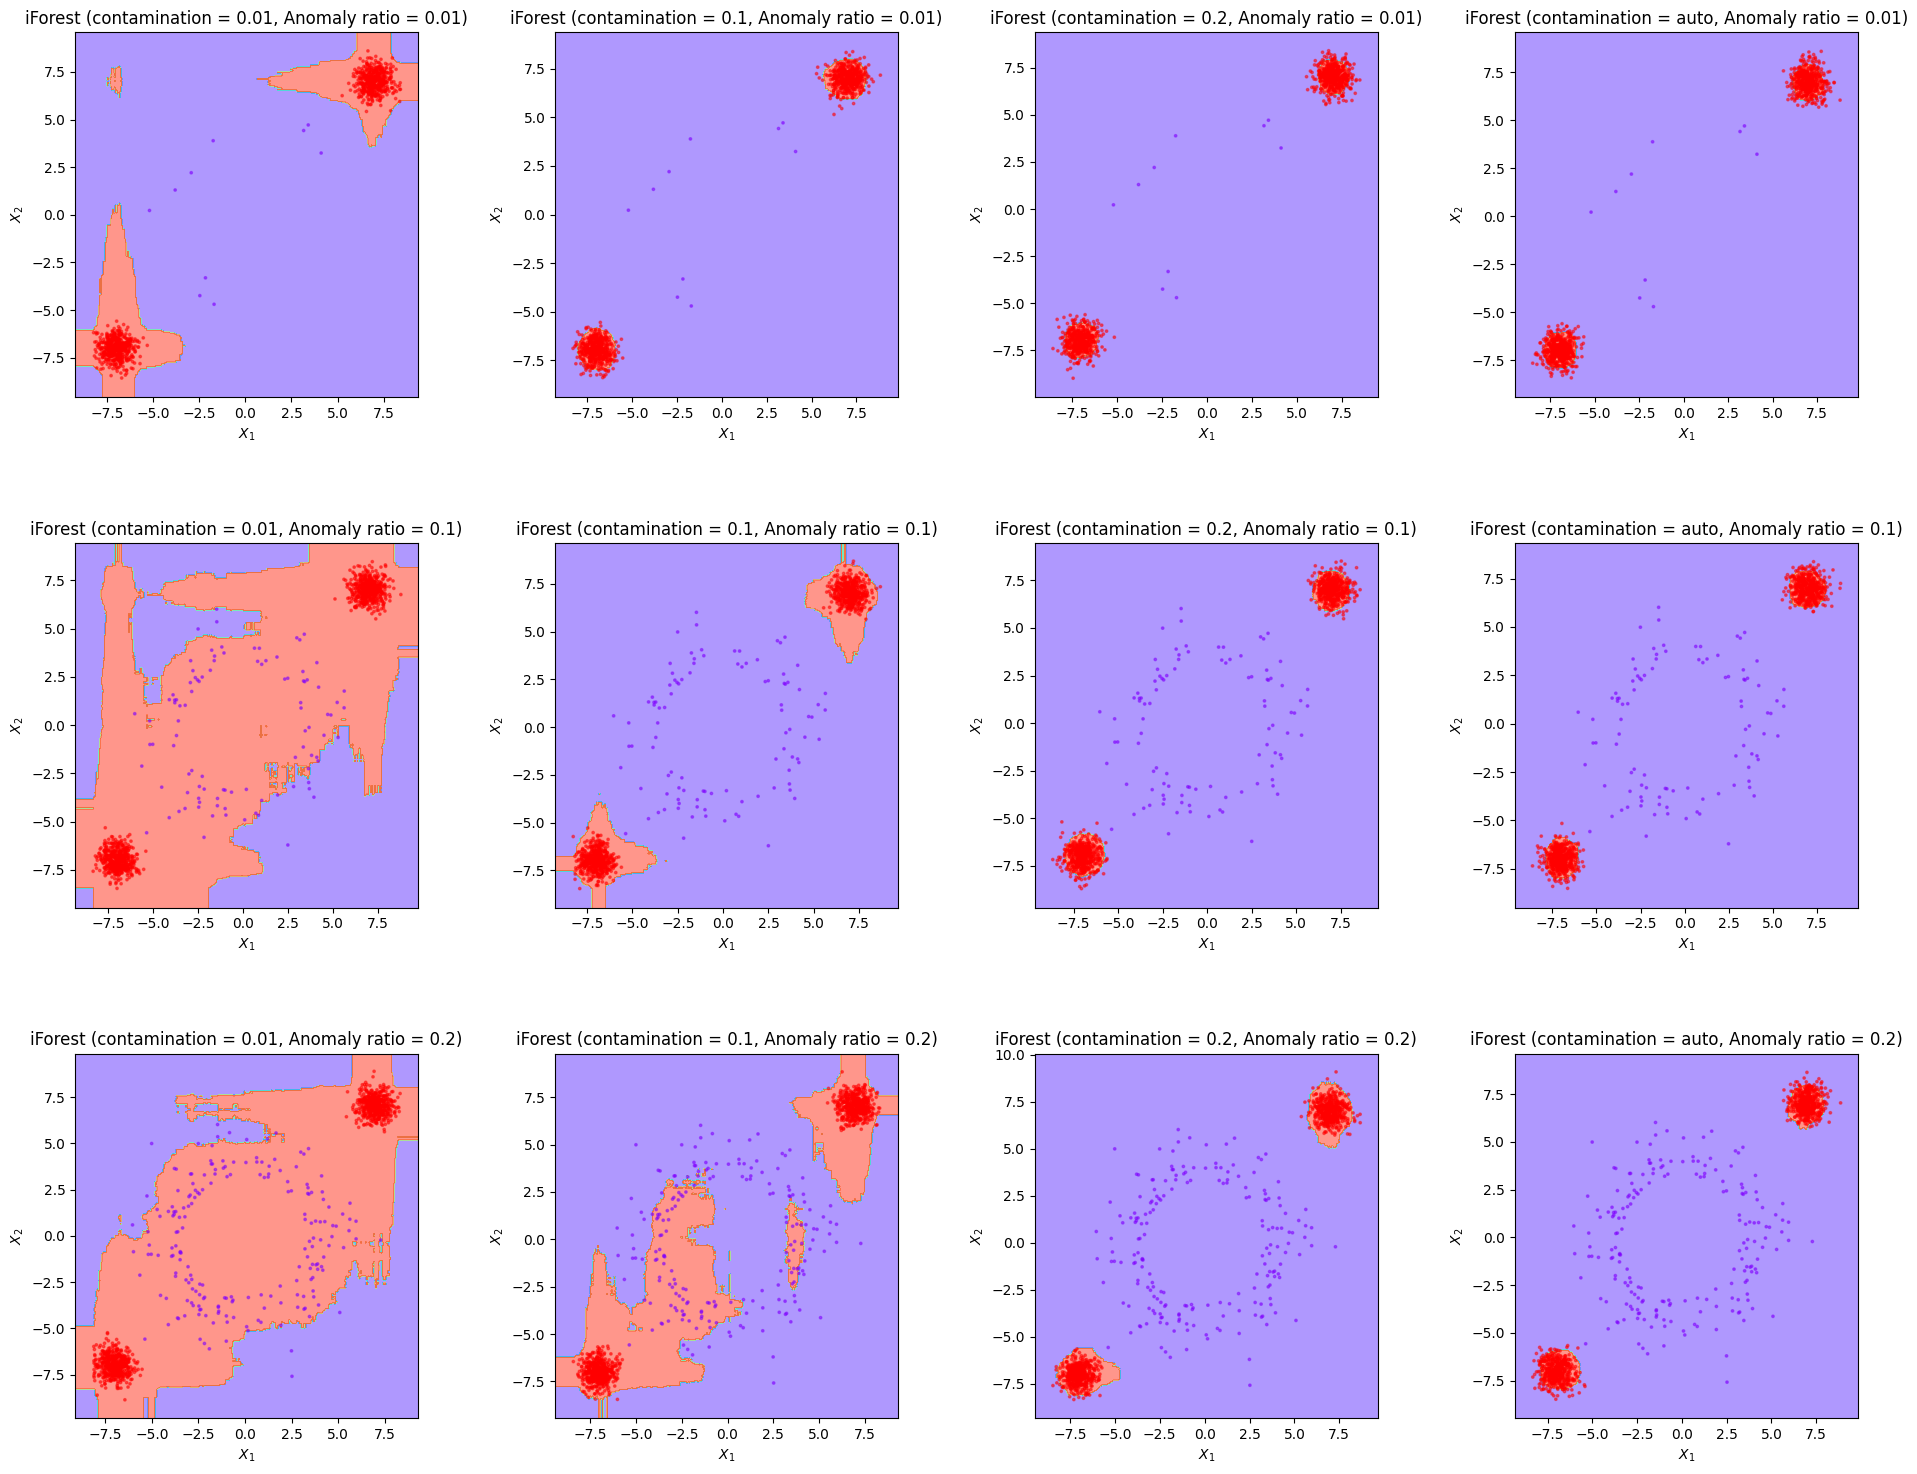

In [44]:
plt.figure(figsize=(23, 18)) 
for i, anomaly_ratio in enumerate([0.01, 0.1, 0.2]):
    for j, contamination in enumerate([0.01, 0.1, 0.2, 'auto']):
        
        X_1,y_1 = make_dataset(1000, 2, 58, anomaly_ratio)

        h = .05
        x_min, x_max = X_1[:, 0].min() - 1, X_1[:, 0].max() + 1
        y_min, y_max = X_1[:, 1].min() - 1, X_1[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        clf = IsolationForest(random_state=0, contamination=contamination).fit(X_1)
        
        
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.subplot(3, 4, (i*4)+j+1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.5)
        plt.scatter(X_1[:, 0], X_1[:, 1], c=y_1, cmap=plt.cm.rainbow, s=3, alpha=0.5)
        plt.title(f'iForest (contamination = {contamination}, Anomaly ratio = {anomaly_ratio})')
        
        plt.xlabel("$X_1$")
        plt.ylabel("$X_2$")

plt.show()

마찬가지로 정상 데이터의 군집이 하나일 때와 비슷한 양상을 보이고 있습니다. 

다만 특이한 점을 하나 확인 할 수 있는데, contamination = 0.01, Anomaly ratio = 0.01로 설정된 제일 왼쪽 위의 결과의 경우 실제 정상 데이터의 분포와 전혀 상관없는 왼쪽 위 구석의 영역이 정상 데이터로 판정되고 있는 모습을 확인 할 수 있습니다.

이는 Isolation Forest가 Decision Tree에 따라 수평 혹은 수직으로 경계선을 그리기 때문에 발생하는 문제점으로, 이를 해결하기 위한 Extended Isolation Forest가 제안 되었습니다.

## Real Data

이제 실제 데이터 셋에 적용해보도록 하겠습니다. 사용된 데이터 셋은 covertype 데이터셋입니다.(https://archive.ics.uci.edu/ml/datasets/covertype)

이 데이터는 미국 삼림을 30×30m 영역으로 나누어 각 영역의 특징으로부터 대표적인 나무의 종류(species of tree)을 예측하기 위한 데이터입니다. 7종류의 수종이 존재합니다. (https://datascienceschool.net/03%20machine%20learning/09.01%20%EB%B6%84%EB%A5%98%EC%9A%A9%20%EC%98%88%EC%A0%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0.html)

원래 데이터는 Classification을 위한 데이터이지만, 가장 수가 많은 Class 하나를 Normal, 나머지를 Anomaly로 하여 실험을 진행해보도록 하겠습니다.

### Load Data

In [10]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()

df = pd.DataFrame(covtype.data, 
                  columns=["x{:02d}".format(i + 1) for i in range(covtype.data.shape[1])],
                  dtype=int)
sy = pd.Series(covtype.target, dtype="category")
df['covtype'] = sy
df.tail()

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x46,x47,x48,x49,x50,x51,x52,x53,x54,covtype
581007,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3
581011,2383,165,13,60,4,67,231,244,141,875,...,0,0,0,0,0,0,0,0,0,3


In [11]:
df['covtype'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: covtype, dtype: int64

원본 데이터는 위와 같이 class 2가 28만개로 가장 많고, class 1이 21만개, 그리고 나머지 class는 3만여개에서부터 3천개까지 클래스 불균형이 존재하는 데이터입니다.

In [12]:
new_df = df[df['covtype'] == 2].sample(20000, random_state=42)
for i in [1,3,4,5,6,7]:
    new_df = pd.concat([new_df, df[df['covtype'] == i].sample(2000, random_state=42)])

In [13]:
new_df['covtype'].value_counts()

2    20000
1     2000
3     2000
4     2000
5     2000
6     2000
7     2000
Name: covtype, dtype: int64

여기서는 빠른 학습을 위해 가장 수가 많은 class 2를 normal로 두어 2만개, 나머지 class에서는 각각 2천개씩 무작위로 추출 하겠습니다.

### Experiment

![image](https://user-images.githubusercontent.com/35906602/202408497-3e70fd1d-cb45-46f6-bde7-01b4ac120198.png)


이제 앞에서 했던 것과 비슷한 방식으로, 데이터에 포함되는 이상 데이터 및 각 모델의 $\nu$ 혹은 contamination 파라미터를 조절하여 성능의 양상을 살펴보도록 하겠습니다.

각 모델에서 Normal 데이터는 20,000개로 고정시키고, 나머지 클래스를 하나씩 이상 데이터로 하여 진행 했습니다.

학습 데이터와 시험 데이터를 3:1 비율로 나누었습니다.

이때 이상 데이터는 2,000개 (10%), 1,000개 (5%), 0개 (0%)를 함께 학습시켰습니다.

정리하면 학습 데이터에는 정상 데이터 15,000개, 이상 데이터 (0, 750, 1,500개) 가 포함되며 시험 데이터에는 정상 데이터 5,000개, 시험 데이터 500개로 구성됩니다.

이때 모델의 다른 파라미터는 전부 모델에 기본적으로 세팅 되어 있는 default 값을 사용하였습니다.

In [86]:
train, test = train_test_split(new_df, test_size=0.25, random_state=42,stratify=new_df['covtype'])

In [87]:
columns = ['Anomaly Class', 'Model', 'Train data Anomaly Ratio', 'nu or contamination', 'f1_score', 'recall_score', 'Time']
results = pd.DataFrame(columns=columns)

In [88]:
for cat in tqdm([1,3,4,5,6,7]) :
    train_normal = train.loc[train['covtype'].isin([2])]
    train_anomaly = train.loc[train['covtype'].isin([cat])]
    
    for anomaly_rate in [0, 0.5, 1]:
        train_anomaly2 = train_anomaly.sample(frac=anomaly_rate, random_state=42)
        train_data = pd.concat([train_normal, train_anomaly2])
        test_data = test.loc[test['covtype'].isin([2, cat])]

        y_train = [1 if i==2 else -1 for i in train_data['covtype']]
        X_train = train_data.drop(columns=['covtype'])
        y_test = [1 if i==2 else -1 for i in test_data['covtype']]
        X_test = test_data.drop(columns=['covtype'])
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for nu in [0.01, 0.05, 0.1, 0.2]:
            start = time.time()
            clf = OneClassSVM(gamma='auto', nu=nu).fit(X_train)
            y_pred = clf.predict(X_test)
            end = round((time.time() - start)*1000, 3)
            
            f1 = f1_score(y_pred, y_test)
            recall = recall_score(y_pred, y_test)
            
            result = [cat,'OCSVM', round(anomaly_rate * 0.1,2), nu, f1, recall, end]
            results.loc[len(results)] = result

  0%|          | 0/6 [00:00<?, ?it/s]

In [89]:
for cat in tqdm([1,3,4,5,6,7]) :
    train_normal = train.loc[train['covtype'].isin([2])]
    train_anomaly = train.loc[train['covtype'].isin([cat])]
    
    for anomaly_rate in [0, 0.5, 1]:
        train_anomaly2 = train_anomaly.sample(frac=anomaly_rate, random_state=42)
        train_data = pd.concat([train_normal, train_anomaly2])
        test_data = test.loc[test['covtype'].isin([2, cat])]


        y_train = [1 if i==2 else -1 for i in train_data['covtype']]
        X_train = train_data.drop(columns=['covtype'])
        y_test = [1 if i==2 else -1 for i in test_data['covtype']]
        X_test = test_data.drop(columns=['covtype'])
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for nu in [0.01, 0.05, 0.1, 0.2, 'auto']:
            start = time.time()
            clf = IsolationForest(random_state=0, contamination=nu).fit(X_train)
            y_pred = clf.predict(X_test)
            end = round((time.time() - start)*1000, 3)
            
            f1 = f1_score(y_pred, y_test)
            recall = recall_score(y_pred, y_test)
            
            result = [cat,'iForest', round(anomaly_rate * 0.1,2), nu, f1, recall, end]
            results.loc[len(results)] = result
    

  0%|          | 0/6 [00:00<?, ?it/s]

In [90]:
pd.set_option('display.max_rows', None)

In [ ]:
results.groupby(['Anomaly Class', 'Train data Anomaly Ratio', 'Model', 'nu or contamination']).agg(['mean'])

f1_score  \
                                                                        mean   
Anomaly Class Train data Anomaly Ratio Model   nu or contamination             
1             0.00                     OCSVM   0.01                 0.947338   
                                               0.05                 0.928135   
                                               0.1                  0.901739   
                                               0.2                  0.854055   
                                       iForest 0.01                 0.948819   
                                               0.05                 0.931210   
                                               0.1                  0.910879   
                                               0.2                  0.860846   
                                               auto                 0.952082   
              0.05                     OCSVM   0.01                 0.946055   
                                               0.05                 0.929539   
                                               0.1                  0.904195   
                                               0.2                  0.854828   
                                       iForest 0.01                 0.948929   
                                               0.05                 0.933359   
                                               0.1                  0.909876   
                                               0.2                  0.858628   
                                               auto                 0.952082   
              0.10                     OCSVM   0.01                 0.946208   
                                               0.05                 0.930160   
                                               0.1                  0.906256   
                                               0.2                  0.855322   
                                       iForest 0.01                 0.947832   
                                               0.05                 0.933788   
                                               0.1                  0.912006   
                                               0.2                  0.862189   
                                               auto                 0.951973   
3             0.00                     OCSVM   0.01                 0.966127   
                                               0.05                 0.955799   
                                               0.1                  0.939937   
                                               0.2                  0.886101   
                                       iForest 0.01                 0.958353   
                                               0.05                 0.947693   
                                               0.1                  0.928586   
                                               0.2                  0.879245   
                                               auto                 0.956638   
              0.05                     OCSVM   0.01                 0.950924   
                                               0.05                 0.942199   
                                               0.1                  0.929560   
                                               0.2                  0.899739   
                                       iForest 0.01                 0.960115   
                                               0.05                 0.959012   
                                               0.1                  0.944676   
                                               0.2                  0.893686   
                                               auto                 0.953289   
              0.10                     OCSVM   0.01                 0.948905   
                                               0.05                 0.938415   
                                               0.1                  

## 정리

![image](https://user-images.githubusercontent.com/35906602/202413717-694aab86-0de5-4557-a905-11e2baf67e5f.png)

각 실험 셋팅별로 F1 Score 성능을 나타낸 표이며, 괄호 안의 수치는 해당 셋팅에서 가장 높은 성능을 보인 $\nu$ 혹은 Contamination 파라미터의 값입니다.

1. 학습 시간의 경우 OCSVM이 대체로 더 높았습니다. 데이터가 더 커질수록 iforest에 비해 상대적으로 더 느려질 것으로 보입니다. 또한 $\nu$ 파라미터가 높을수록 학습 시간이 몇십배 가까이 차이가 나기도 했습니다.

2. 앞선 2차원 데이터로 살펴 보았을 때는 OCSVM의 $\nu$ 혹은 iForest의 Contamination 파라미터가 학습 데이터의 이상 데이터 비율과 비슷할 수록 더 좋은 성능을 낼 것이라고 보았는데, 실제 결과는 전혀 다르게 나왔습니다. OCSVM의 경우 이상 데이터의 비율과 상관없이 모든 경우에 $\nu$ 파라미터가 0.01로 가장 낮게 설정 되었을 때 더 좋은 성능을 보였습니다. iForest의 경우에는 Contamination 파라미터가 자동으로 셋팅되는 'auto' 일 때 가장 좋은 성능을 보인 경우가 많았지만, 0.01 일 때도 거의 같은 성능을 보였습니다. 데이터의 특성에 따라 항상 이상 데이터의 비율과 비슷한 값을 주는 것이 최선이 아닐 수도 있다는 점을 알 수 있습니다.


![image](https://user-images.githubusercontent.com/35906602/202417631-3ddd3219-91ae-4be6-9d04-00f09bfc9866.png)


위 표는 각 실험 셋팅별로 F1 Score를 평균 낸 값입니다. 괄호 안의 수치는 해당 셋팅에서 $\nu$ 혹은 Contamination의 파라미터의 변화에 따라 파라미터가 0.01일 때에 비해 성능 저하가 얼마나 있었는 지를 나타낸 수치입니다.

1. OCSVM과 iForest 둘 다 이상치 비율과 상관없이 $\nu$ 혹은 contamination이 0.01 일 때 가장 좋은 성능을 보였습니다.

2. OCSVM의 경우 학습 데이터에 이상 데이터가 섞일수록 성능이 저하됩니다.

3. iForest의 경우 학습 데이터에 이상 데이터가 섞여도 크게 영향을 받지 않았습니다.

4. iForest에서 Contamination을 'auto'로 설정한 경우 항상 높은 성능을 보였습니다.

5. OCSVM이 iForest에 비해 $\nu$ 혹은 contamination 파라미터에 따른 성능 저하폭이 더 컸습니다.

## 결론

1. OCSVM의 경우 $\nu$ 파라미터에 따라 상대적으로 성능이 크게 차이납니다. 따라서 하이퍼파라미터 튜닝이 필요합니다.

2. iForest의 경우 contamination 파라미터에 따라 성능이 차이가 나지만, iForest 논문 저자가 제안하는 방법을 사용하면 좋은 성능을 보이므로 더 강건하다고 볼 수 있습니다.

3. $\nu$ 혹은 contamination 파라미터의 값이 실제 데이터에 섞여있는 이상치 비율과 비슷하다고 항상 좋은 성능을 보여주지는 않습니다.

4. 전반적인 성능에는 두 모델이 큰 차이를 보이지는 않았습니다. 하지만 하나의 데이터셋에만 실험했으므로 일반화 할 수는 없습니다.